# Segment customers of an e-commerce

## *Maintenance contract (part 3)*

My mission for <strong>Olist</strong> is to provide its e-commerce teams with customer segmentation that they can use on a daily basis for their communication campaigns.<br><br>
My goal is to understand different types of users through their behavior and personal data.<br><br>
I must provide the marketing team with an actionable description of their segmentation and its underlying logic for optimal use, as well as a maintenance contract proposal based on an analysis of the stability of the segments over time.

<u><strong>Summary</strong></u> :<br>
<br>
<strong>Tools</strong> [(here)](#another_cell_0)<br><br>
<strong>III. Maintenance contract</strong><br>
     -- A. K-means classification of Olist customers who purchased in 2016 and 2017<br>
     ---- <i>☛ Data preprocessing<br>
     ---- ☛ KMeans clustering on data before 2018</i>    
     -- B. Adjusted Rand Index on customers data until 2018<br>
     ---- <i>☛ Adjusted Rand Index of KMeans model on previous 2018 customer data<br>
     ---- ☛ Adjusted Rand Index of the KMeans model on previous February 2018 customer data<br></i>  
<strong>Conclusion (part 3) </strong> [(here)](#another_cell_l)

<a id='another_cell_0'></a>

### Tools

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
import warnings
import random
warnings.filterwarnings('ignore')

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score

In [2]:
# Read Olist data before standardization
data = pd.read_csv('agg_data_xprt.csv', sep=';')
data = data.drop(columns=["Unnamed: 0"])

In [3]:
# Read RFM stansardized data + review_score
data_ = pd.read_csv('export_olist_standardized_data_rmf_review.csv', sep=';')
standardized_data = data_.drop(columns=["Unnamed: 0"])

## I. Maintenance contract

### A. K-means classification of Olist customers who purchased in 2016 and 2017

- **Data preprocessing**

In [4]:
data.head()

,customer_id,customer_city,customer_state,nb_of_orders,preferred_purchasing_category,most_recent_purchase_date,payment_value,payment_installments,review_score
0,00012a2ce6f8dcda20d059ce98491703,osasco,SP,1,brinquedos,14/11/2017 16:08,114.74,8,1.0
1,000161a058600d5901f007fab4c27140,itapecerica,MG,1,beleza_saude,16/07/2017 09:40,67.41,5,4.0
2,0001fd6190edaaf884bcaf3d49edf079,nova venecia,ES,1,bebes,28/02/2017 11:06,195.42,10,5.0
3,0002414f95344307404f0ace7a26f1d5,mendonca,MG,1,cool_stuff,16/08/2017 13:09,179.35,1,5.0
4,000379cdec625522490c315e70c7a9fb,sao paulo,SP,1,cama_mesa_banho,02/04/2018 13:42,107.01,1,4.0


<div class="alert-success">
<strong>→ We will train our KMeans classification model on data from customers who made a purchase on Olist strictly before 2018</strong>
</div>

In [5]:
# Convert most_recent_purchase_date column to datetime format
data['most_recent_purchase_date'] = pd.to_datetime(data['most_recent_purchase_date'], format='%d/%m/%Y %H:%M')
# Deadline for division (01/01/2018)
deadline = pd.to_datetime('01/01/2018', format='%d/%m/%Y')
print(f"Deadline : {deadline}")

Deadline : 2018-01-01 00:00:00


In [6]:
# Split the DataFrame into two DataFrames
before_deadline = data[data['most_recent_purchase_date'] < deadline]
after_deadline = data[data['most_recent_purchase_date'] >= deadline]
before_deadline['most_recent_purchase_date'].max()

Timestamp('2017-12-31 23:29:00')

In [7]:
# List of customer_ids having consumed before the deadline
customer_ids_before = before_deadline['customer_id'].tolist()
customer_ids_before

['00012a2ce6f8dcda20d059ce98491703',
 '000161a058600d5901f007fab4c27140',
 '0001fd6190edaaf884bcaf3d49edf079',
 '0002414f95344307404f0ace7a26f1d5',
 '0004164d20a9e969af783496f3408652',
 '00046a560d407e99b969756e0b10f282',
 '00050bf6e01e69d5c0fd612f1bcfb69c',
 '00062b33cb9f6fe976afdcff967ea74d',
 '00072d033fe2e59061ae5c3aff1a2be5',
 '0009a69b72033b2d0ec8c69fc70ef768',
 '000bf8121c3412d3057d32371c5d3395',
 '000e943451fc2788ca6ac98a682f2f49',
 '000f17e290c26b28549908a04cfe36c1',
 '0010068a73b7c56da5758c3f9e5c7375',
 '00114026c1b7b52ab1773f317ef4880b',
 '001226b2341ef620415ce7bbafcfac28',
 '00155f0530cc7b2bf73cc3f81cb01c52',
 '0015f7887e2fde13ddaa7b8e385af919',
 '0018f7fde63ca77254dbc47f4ea358b2',
 '001f6f1a5e902ad14e1f709a7215de11',
 '002450e9ea44cb90b8a07ba0b197e149',
 '002834b4d901534f48d9e9a72047b288',
 '002937abdae13680e17dccd3868b4825',
 '002c625393dfa194828b462a6ef8cb0b',
 '002f067b028a3643ad3a0969c7a0f3dc',
 '002f90a6eb386bc43bc9ba200db31a89',
 '002fb8fc5ce64f8422fa2fe79986c783',
 

In [8]:
print(f"There are {len(customer_ids_before)} customers in our dataframe before June 2017.")

There are 42815 customers in our dataframe before June 2017.


In [9]:
# Filter the df standardized_data with the list of customer_ids_before
data_before_2018 = standardized_data[standardized_data['customer_id'].isin(customer_ids_before)]
data_before_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42815 entries, 0 to 94544
Data columns (total 5 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   customer_id                             42815 non-null  object 
 1   nb_of_orders                            42815 non-null  float64
 2   payment_value                           42815 non-null  float64
 3   review_score                            42815 non-null  float64
 4   standardized_most_recent_purchase_date  42815 non-null  int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 2.0+ MB


- **KMeans clustering on data before 2018**

In [10]:
data_before_2018 = data_before_2018.set_index('customer_id')

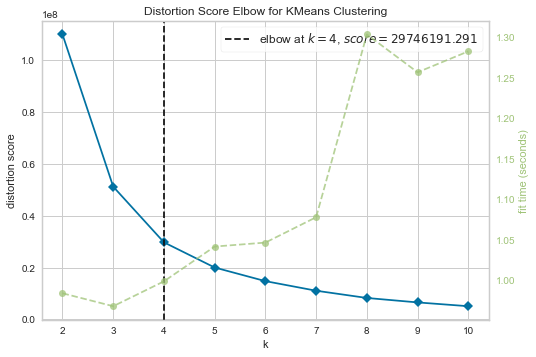

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [11]:
model = KElbowVisualizer(KMeans(), k=10)
model.fit(data_before_2018)
model.show()

<div class="alert-success">
    <u>Notice</u> :
<i><br><li>According to the elbow curve, the optimal number of clusters is 4
</i></div>

In [12]:
# K-Means model with 4 clusters
model_kmeans = KMeans(n_clusters=4)
model_kmeans.fit(data_before_2018)

KMeans(n_clusters=4)

In [13]:
# Silhouette score calculation
labels = model_kmeans.labels_
silhouette_avg = silhouette_score(data_before_2018, labels)
print(f"Silhouette score : {silhouette_avg}")

Silhouette score : 0.5876579351425315


### B. Adjusted Rand Index on customers data until 2018

<a id='another_cell_k'></a>

- **Adjusted Rand Index of KMeans model on previous 2018 customer data**

In [14]:
# Determine which clusters each data point belongs to
clusters =  model_kmeans.fit_predict(data_before_2018)

# Add the cluster number to the original scaled data
X_clustered = pd.DataFrame(data_before_2018, index=data_before_2018.index, columns=data_before_2018.columns)
X_clustered["cluster"] = clusters

In [15]:
# Adjusted Rand Index calculation
labels = model_kmeans.labels_
ari = adjusted_rand_score(X_clustered["cluster"], labels)
print("Adjusted Rand Index on previous 2018 customer data:", ari)

Adjusted Rand Index on previous 2018 customer data: 1.0


- **Adjusted Rand Index of the KMeans model on previous February 2018 customer data**

In [16]:
# Deadline for division (01/02/2018)
deadline_fev_2018 = pd.to_datetime('01/02/2018', format='%d/%m/%Y')
print(f"Deadline February 2018 : {deadline}")

Deadline February 2018 : 2018-01-01 00:00:00


In [17]:
# Split the DataFrame into two DataFrames
before_deadline_fev_2018 = data[data['most_recent_purchase_date'] < deadline_fev_2018]
after_deadline_fev_2018 = data[data['most_recent_purchase_date'] >= deadline_fev_2018]
before_deadline_fev_2018['most_recent_purchase_date'].max()

Timestamp('2018-01-31 23:58:00')

In [18]:
# List of customer_ids having consumed before the deadline
customer_ids_before_fev_2018 = before_deadline_fev_2018['customer_id'].tolist()
customer_ids_before_fev_2018

['00012a2ce6f8dcda20d059ce98491703',
 '000161a058600d5901f007fab4c27140',
 '0001fd6190edaaf884bcaf3d49edf079',
 '0002414f95344307404f0ace7a26f1d5',
 '0004164d20a9e969af783496f3408652',
 '00046a560d407e99b969756e0b10f282',
 '00050bf6e01e69d5c0fd612f1bcfb69c',
 '00062b33cb9f6fe976afdcff967ea74d',
 '00072d033fe2e59061ae5c3aff1a2be5',
 '0009a69b72033b2d0ec8c69fc70ef768',
 '000bf8121c3412d3057d32371c5d3395',
 '000e943451fc2788ca6ac98a682f2f49',
 '000f17e290c26b28549908a04cfe36c1',
 '0010068a73b7c56da5758c3f9e5c7375',
 '00104a47c29da701ce41ee52077587d9',
 '00114026c1b7b52ab1773f317ef4880b',
 '001226b2341ef620415ce7bbafcfac28',
 '0013280441d86a4f7a8006efdaf1b0fe',
 '00146ad30454993879adaa91c518f68c',
 '00155f0530cc7b2bf73cc3f81cb01c52',
 '0015f7887e2fde13ddaa7b8e385af919',
 '0018f7fde63ca77254dbc47f4ea358b2',
 '001a57041f56400917a187dd74e6cbc1',
 '001f35d9f262c558fd065346fbf5801d',
 '001f6f1a5e902ad14e1f709a7215de11',
 '002236c4f333bc8df6a5939749eb7869',
 '002408f390f729598bbac1ef9421c6ae',
 

In [19]:
print(f"There are {len(customer_ids_before_fev_2018) - len(customer_ids_before)} customers in our dataframe between June 2017 and December 2017.")

There are 6931 customers in our dataframe between June 2017 and December 2017.


In [20]:
# Combined the 2 customers lists
customer_ids_before_fev_2018 = customer_ids_before_fev_2018 + customer_ids_before

In [21]:
# Filter the df standardized_data with the list of customer_ids_before_fev
data_before_fev_2018 = standardized_data[standardized_data['customer_id'].isin(customer_ids_before_fev_2018)]
data_before_fev_2018 = data_before_fev_2018.set_index('customer_id')
data_before_fev_2018.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49746 entries, 00012a2ce6f8dcda20d059ce98491703 to ffffa3172527f765de70084a7e53aae8
Data columns (total 4 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   nb_of_orders                            49746 non-null  float64
 1   payment_value                           49746 non-null  float64
 2   review_score                            49746 non-null  float64
 3   standardized_most_recent_purchase_date  49746 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 1.9+ MB


In [22]:
# Determine which clusters each data point belongs to
clusters_fev_2018 =  model_kmeans.fit_predict(data_before_fev_2018)

# Add the cluster number to the original scaled data
X_clustered_fev_2018 = pd.DataFrame(data_before_fev_2018, index=data_before_fev_2018.index, columns=data_before_fev_2018.columns)
X_clustered_fev_2018["cluster"] = clusters_fev_2018

In [23]:
X_clustered_fev_2018 = X_clustered_fev_2018.reset_index(drop=False)
X_clustered_fev_2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49746 entries, 0 to 49745
Data columns (total 6 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   customer_id                             49746 non-null  object 
 1   nb_of_orders                            49746 non-null  float64
 2   payment_value                           49746 non-null  float64
 3   review_score                            49746 non-null  float64
 4   standardized_most_recent_purchase_date  49746 non-null  int64  
 5   cluster                                 49746 non-null  int32  
dtypes: float64(3), int32(1), int64(1), object(1)
memory usage: 2.1+ MB


In [24]:
# Filter the df X_clustered_fev_2018 with the list of customer_ids_before
filtered_data_before_2018 = X_clustered_fev_2018[X_clustered_fev_2018['customer_id'].isin(customer_ids_before)]
filtered_data_before_2018 = filtered_data_before_2018.set_index('customer_id')
filtered_data_before_2018.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42815 entries, 00012a2ce6f8dcda20d059ce98491703 to ffffa3172527f765de70084a7e53aae8
Data columns (total 5 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   nb_of_orders                            42815 non-null  float64
 1   payment_value                           42815 non-null  float64
 2   review_score                            42815 non-null  float64
 3   standardized_most_recent_purchase_date  42815 non-null  int64  
 4   cluster                                 42815 non-null  int32  
dtypes: float64(3), int32(1), int64(1)
memory usage: 1.8+ MB


In [25]:
# Adjusted Rand Index calculation
ari_fev_2018 = adjusted_rand_score(filtered_data_before_2018["cluster"], X_clustered["cluster"])
print("Adjusted Rand Index on previous February 2018 customer data:", ari_fev_2018)

Adjusted Rand Index on previous February 2018 customer data: 0.7177391078489068


<a id='another_cell_l'></a>

### Conclusion (part 3)

<div class="alert-success">

**The ARI (Adjusted Rand Index) is a measure of similarity between two datasets**, often used to evaluate the performance of unsupervised classification models such as K-means. An ARI of 1.00 indicates a perfect match between the actual clusters and the clusters predicted by the model, while an ARI of 0.72 shows a drop in similarity from the previous measurement.

**A significant drop in the ARI of a K-means model from one evaluation to the next can indicate several things in the context of a maintenance contract :**
- **Changes in upstream data**: It is possible that the data itself has changed over time.
- **Model Degradation**: There could be issues with the model itself. Perhaps parts of the model need to be retrained or recalibrated.</i><br>

**→ It therefore seems necessary to retrain the model with up-to-date data every month in order to maintain the quality of customer segmentation.**
</div>